<a href="https://colab.research.google.com/github/abel-keya/linear-regression-optimization/blob/master/Linear_regression_detecting%20multicolinearity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: Detecting multicollinearity

We will once again use our university admission [dataset](https://)

First, let's understand how our independent variables are correlated to each other

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load the dataset
data = pd.read_csv('uni_admission.csv')

# Remove the serial and admit chance columns, we want to focus on our independent variables only.
independent_only = data.drop(columns=['Serial No.', 'admit_chance'])

# Let's display the correlations between the variables
correlations = independent_only.corr()

correlations

,GRE,TOEFL,uni_rating,SOP,LOR,CGPA,publications
GRE,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398
TOEFL,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012
uni_rating,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526
CGPA,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311
publications,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000


The tabe above shows us how each variable relates to another. The coefficient of 1 across the diagonal makes sense, as a variable is perfectly correlated to itself. Let's use these correlations to compute the VIF score for each variable. This will require a little bit of linear algebra, but the approach is straightforward: we create a new dataframe with the *inverse* of the matrix above.

In [8]:
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)


,GRE,TOEFL,uni_rating,SOP,LOR,CGPA,publications
GRE,4.464249,-1.919309,-0.167441,0.115539,0.163716,-1.829666,-0.738214
TOEFL,-1.919309,3.904213,-0.280590,-0.320530,0.008925,-1.216918,0.115389
uni_rating,-0.167441,-0.280590,2.621036,-1.003439,-0.326820,-0.504916,-0.109544
SOP,0.115539,-0.320530,-1.003439,2.835210,-0.715324,-0.670228,-0.041512
LOR,0.163716,0.008925,-0.326820,-0.715324,2.033555,-0.650578,-0.096312
CGPA,-1.829666,-1.216918,-0.504916,-0.670228,-0.650578,4.777992,-0.064604
publications,-0.738214,0.115389,-0.109544,-0.041512,-0.096312,-0.064604,1.494008


Interpreting the table is straightforward: The VIF score for each variable is found alongside the downwards sloping diagonal. GRE has a score of 4.46, TOEFL has a score of 3.9, uni_rating a score of 2.62, etc.

CGPA has a value nearing 5, let's see how the VIF scores improve if we remove it from our dataset

In [9]:
revised = independent_only.drop(columns=['CGPA'])

correlations = revised.corr()
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)



,GRE,TOEFL,uni_rating,SOP,LOR,publications
GRE,3.763604,-2.385311,-0.360792,-0.141115,-0.085414,-0.762953
TOEFL,-2.385311,3.594274,-0.409188,-0.491232,-0.156772,0.098934
uni_rating,-0.360792,-0.409188,2.567679,-1.074266,-0.395570,-0.116371
SOP,-0.141115,-0.491232,-1.074266,2.741195,-0.806583,-0.050574
LOR,-0.085414,-0.156772,-0.395570,-0.806583,1.944971,-0.105109
publications,-0.762953,0.098934,-0.116371,-0.050574,-0.105109,1.493134


All scores dropped, but the GRE's in particular did quite a bit, indicating that GRE and CGPA were colinear. 

# Example 2: Residual plots and heteroskedasticity testing

Let's start by creating a model based on our revised set of independent variables above, then displaying the residual plot for it.

In [10]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = revised.values
y = data['admit_chance'].values

X_train, X_test, admit_train, admit_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, admit_train)

# This is our prediction for admission based on our model
admit_predict = regressor.predict(X_test)

# We now create the residual by substracting the test value from the predicted 
# value for each row in our dataset

residuals = np.subtract(admit_predict, admit_test)

# Let's describe our residual:
pd.DataFrame(residuals).describe()

residuals.mean()

-0.0017516644688065042

Before we interpret the description above, let's recall what we are trying to predict: The percentage chance of admission to university. This means values between 0 and 1. 

Our min and max for the residual are fairly high: they suggest we've been up to 26% off target. It's important for us to plot this first: Is this a common occurence, or a few outliers?

Our mean on the other hand is close to 0, indicating that we tend to be fairly correct, although slightly over estimating chances by, on average, 0.17%

Let's show the residual plot

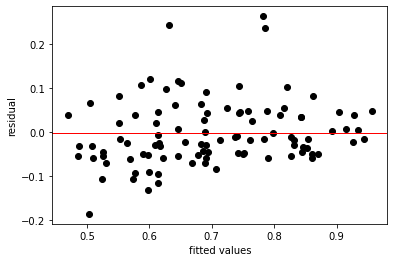

In [11]:
import matplotlib.pyplot as plt

plt.scatter(admit_predict, residuals, color='black')
plt.ylabel('residual')
plt.xlabel('fitted values')
plt.axhline(y= residuals.mean(), color='red', linewidth=1)
plt.show()

This does not look too bad: our residuals are centered around a mean that is very close to 0, and there are no glaringly obvious patterns. Let's be thorough though, and perform a heteroskedasticity test.

For this we will use [bartlett's test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm). The test establishes as a null hypothesis that the variance is equal for all our datapoints,and the new hypothesis that the variance is different for at least one pair of datapoints.


In [14]:
import scipy as sp

test_result, p_value = sp.stats.bartlett(admit_predict, residuals)

# To interpret the results we must also compute a critical value of the chi squared distribution
degree_of_freedom = len(admit_predict)-1
probability = 1 - p_value

critical_value = sp.stats.chi2.ppf(probability, degree_of_freedom)
print(critical_value)

# If the test_result is greater than the critical value, then we reject our null
# hypothesis. This would mean that there are patterns to the variance of the data

# Otherwise, we can identify no patterns, and we accept the null hypothesis that 
# the variance is homogeneous across our data

if (test_result > critical_value):
  print('the variances are unequal, and the model should be reassessed')
else:
  print('the variances are homogeneous!')



185.4720823514965
the variances are homogeneous!


# Challenge

We will bring this all together by adapting a challenge from data.world. In the code section below you have access to a large dataset with demographic and medical data for cancer occurances in regions in the US. Your aim is to build a model that predicts the **target_deathrate** variable. You can find descriptions of all the columns [here](https://data.world/exercises/linear-regression-exercise-1)

This is a holistic challenge:


*   Make sure to clean up your data first, there are some missing elements.
*   Some data should be changed: Add a **state** column which indicates the state a person lives in(you can modify the geography column). Perform a multicollinearity test: Should **state** be included in your model or not?
* If it should be, make sure to transform it since we want to be dealing with numerical data.
* Build a model, then display the residual plot for it. Perform a Bartlett test to determine if your model is acceptable or not.





In [15]:
# Your code goes here!
df = pd.read_csv('https://query.data.world/s/4n3rdrpeu6qrfo63yacah7v3ofoaag')
df.head(5)

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [16]:
df.shape

(3047, 33)

In [17]:
df.describe()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,medianagefemale,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3.047000e+03,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,762.000000,3047.000000,3047.000000,3047.000000,2895.000000,3047.000000,3047.000000,2438.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,606.338544,185.965868,178.664063,448.268586,47063.281917,1.026374e+05,16.878175,155.399415,45.272333,39.570725,42.145323,51.773679,18.224450,35.002068,40.977034,6.158287,34.804660,13.282015,54.152642,7.852412,64.354939,48.453774,41.196324,36.252642,19.240072,83.645286,9.107978,1.253965,1.983523,51.243872,5.640306
std,1416.356223,504.134286,27.751511,54.560733,12040.090836,3.290592e+05,6.409087,529.628366,45.304480,5.226017,5.292849,6.896928,8.093064,9.069722,11.115805,4.529059,7.034924,5.394756,8.315064,3.452371,10.647057,10.083006,9.447687,7.841741,6.113041,16.380025,14.534538,2.610276,3.517710,6.572814,1.985816
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,22.300000,23.100000,0.000000,0.000000,7.100000,0.000000,7.500000,2.500000,17.600000,0.400000,22.300000,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38882.500000,1.168400e+04,12.150000,0.000000,37.700000,36.350000,39.100000,47.750000,12.800000,29.200000,34.000000,3.100000,30.400000,9.400000,48.600000,5.500000,57.200000,41.000000,34.500000,30.900000,14.850000,77.296180,0.620675,0.254199,0.295172,47.763063,4.521419
50%,171.000000,61.000000,178.100000,453.549422,45207.000000,2.664300e+04,15.900000,0.000000,41.000000,39.600000,42.400000,52.400000,17.100000,34.700000,40.400000,5.400000,35.300000,12.300000,54.500000,7.600000,65.100000,48.700000,41.100000,36.300000,18.800000,90.059774,2.247576,0.549812,0.826185,51.669941,5.381478
75%,518.000000,149.000000,195.200000,480.850000,52492.000000,6.867100e+04,20.400000,83.650776,44.000000,42.500000,45.300000,56.400000,22.700000,40.700000,46.400000,8.200000,39.650000,16.100000,60.300000,9.700000,72.100000,55.600000,47.700000,41.550000,23.100000,95.451693,10.509732,1.221037,2.177960,55.395132,6.493677
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,65.700000,72.500000,64.100000,72.500000,79.000000,51.800000,54.800000,42.200000,80.100000,29.400000,92.300000,78.900000,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,41.930251,78.075397,21.326165


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avganncount              3047 non-null   float64
 1   avgdeathsperyear         3047 non-null   int64  
 2   target_deathrate         3047 non-null   float64
 3   incidencerate            3047 non-null   float64
 4   medincome                3047 non-null   int64  
 5   popest2015               3047 non-null   int64  
 6   povertypercent           3047 non-null   float64
 7   studypercap              3047 non-null   float64
 8   binnedinc                3047 non-null   object 
 9   medianage                3047 non-null   float64
 10  medianagemale            3047 non-null   float64
 11  medianagefemale          3047 non-null   float64
 12  geography                3047 non-null   object 
 13  percentmarried           3047 non-null   float64
 14  pctnohs18_24            

In [19]:
df.dtypes

avganncount                float64
avgdeathsperyear             int64
target_deathrate           float64
incidencerate              float64
medincome                    int64
popest2015                   int64
povertypercent             float64
studypercap                float64
binnedinc                   object
medianage                  float64
medianagemale              float64
medianagefemale            float64
geography                   object
percentmarried             float64
pctnohs18_24               float64
pcths18_24                 float64
pctsomecol18_24            float64
pctbachdeg18_24            float64
pcths25_over               float64
pctbachdeg25_over          float64
pctemployed16_over         float64
pctunemployed16_over       float64
pctprivatecoverage         float64
pctprivatecoveragealone    float64
pctempprivcoverage         float64
pctpubliccoverage          float64
pctpubliccoveragealone     float64
pctwhite                   float64
pctblack            

In [20]:
sum(df.isna().any())

3

In [21]:
df.fillna(df.mean())

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.900000,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.900000,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.900000,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.300000,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.200000,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,41.1,48.8,"Ellsworth County, Kansas",51.0,20.9,27.9,40.977034,8.4,32.2,15.2,51.700000,4.3,78.3,54.900000,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,29.3,31.4,"Finney County, Kansas",52.6,26.7,33.9,35.600000,3.8,23.1,12.4,70.100000,4.6,64.5,53.300000,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,30.5,31.2,"Ford County, Kansas",54.8,19.7,44.5,33.300000,2.5,23.0,12.8,64.800000,6.4,62.0,52.600000,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,36.9,40.5,"Franklin County, Kansas",58.8,10.9,37.2,40.977034,4.1,36.1,14.4,54.152642,6.9,75.9,56.300000,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


In [22]:
df.isna().any()

avganncount                False
avgdeathsperyear           False
target_deathrate           False
incidencerate              False
medincome                  False
popest2015                 False
povertypercent             False
studypercap                False
binnedinc                  False
medianage                  False
medianagemale              False
medianagefemale            False
geography                  False
percentmarried             False
pctnohs18_24               False
pcths18_24                 False
pctsomecol18_24             True
pctbachdeg18_24            False
pcths25_over               False
pctbachdeg25_over          False
pctemployed16_over          True
pctunemployed16_over       False
pctprivatecoverage         False
pctprivatecoveragealone     True
pctempprivcoverage         False
pctpubliccoverage          False
pctpubliccoveragealone     False
pctwhite                   False
pctblack                   False
pctasian                   False
pctotherra

In [23]:
df.dropna

<bound method DataFrame.dropna of       avganncount  avgdeathsperyear  ...  pctmarriedhouseholds  birthrate
0     1397.000000               469  ...             52.856076   6.118831
1      173.000000                70  ...             45.372500   4.333096
2      102.000000                50  ...             54.444868   3.729488
3      427.000000               202  ...             51.021514   4.603841
4       57.000000                26  ...             54.027460   6.796657
...           ...               ...  ...                   ...        ...
3042  1962.667684                15  ...             51.063830   7.773512
3043  1962.667684                43  ...             52.007937   8.186470
3044  1962.667684                46  ...             55.153949   7.809192
3045  1962.667684                52  ...             58.484232   7.582938
3046  1962.667684                48  ...             56.040242   8.981723

[3047 rows x 33 columns]>

In [24]:
df.isna().any()

avganncount                False
avgdeathsperyear           False
target_deathrate           False
incidencerate              False
medincome                  False
popest2015                 False
povertypercent             False
studypercap                False
binnedinc                  False
medianage                  False
medianagemale              False
medianagefemale            False
geography                  False
percentmarried             False
pctnohs18_24               False
pcths18_24                 False
pctsomecol18_24             True
pctbachdeg18_24            False
pcths25_over               False
pctbachdeg25_over          False
pctemployed16_over          True
pctunemployed16_over       False
pctprivatecoverage         False
pctprivatecoveragealone     True
pctempprivcoverage         False
pctpubliccoverage          False
pctpubliccoveragealone     False
pctwhite                   False
pctblack                   False
pctasian                   False
pctotherra

In [0]:
#pctsomecol18_24             True
mean1=df['pctsomecol18_24'].mean()
df['pctsomecol18_24'].fillna(mean1,inplace=True)
#pctemployed16_over          True
mean2=df['pctemployed16_over'].mean()
df['pctemployed16_over'].fillna(mean2,inplace=True)
#pctprivatecoveragealone     True
mean3=df['pctprivatecoveragealone'].mean()
df['pctprivatecoveragealone'].fillna(mean3,inplace=True)

In [26]:
df.isna().any()

avganncount                False
avgdeathsperyear           False
target_deathrate           False
incidencerate              False
medincome                  False
popest2015                 False
povertypercent             False
studypercap                False
binnedinc                  False
medianage                  False
medianagemale              False
medianagefemale            False
geography                  False
percentmarried             False
pctnohs18_24               False
pcths18_24                 False
pctsomecol18_24            False
pctbachdeg18_24            False
pcths25_over               False
pctbachdeg25_over          False
pctemployed16_over         False
pctunemployed16_over       False
pctprivatecoverage         False
pctprivatecoveragealone    False
pctempprivcoverage         False
pctpubliccoverage          False
pctpubliccoveragealone     False
pctwhite                   False
pctblack                   False
pctasian                   False
pctotherra

In [27]:
sum(df.duplicated())

0

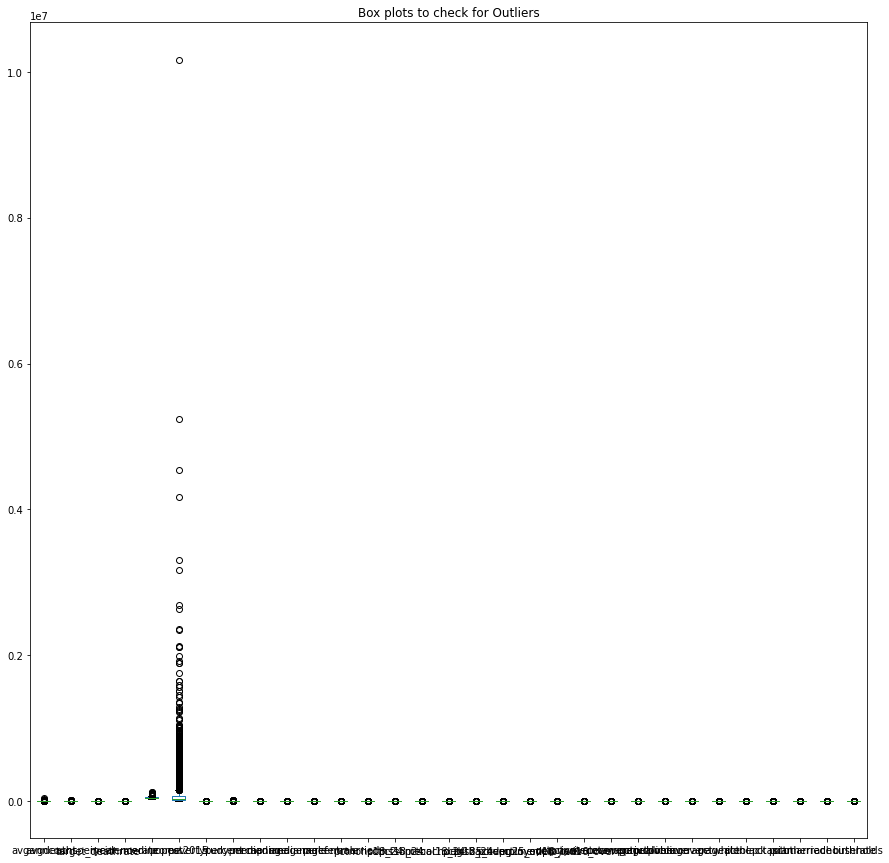

In [28]:
df.plot(kind='box',title='Box plots to check for Outliers',color='',figsize=(15,15));


In [29]:
df_h=df[df['geography'].str.contains(',')]
df_h.head

<bound method NDFrame.head of       avganncount  avgdeathsperyear  ...  pctmarriedhouseholds  birthrate
0     1397.000000               469  ...             52.856076   6.118831
1      173.000000                70  ...             45.372500   4.333096
2      102.000000                50  ...             54.444868   3.729488
3      427.000000               202  ...             51.021514   4.603841
4       57.000000                26  ...             54.027460   6.796657
...           ...               ...  ...                   ...        ...
3042  1962.667684                15  ...             51.063830   7.773512
3043  1962.667684                43  ...             52.007937   8.186470
3044  1962.667684                46  ...             55.153949   7.809192
3045  1962.667684                52  ...             58.484232   7.582938
3046  1962.667684                48  ...             56.040242   8.981723

[3047 rows x 33 columns]>

In [30]:
df_h.head(5)

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.9,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.9,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.9,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.3,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.2,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [0]:
df1=df_h.copy()
df2=df_h.copy()

In [0]:
split_columns=['geography']

In [0]:
for c in split_columns:
    df1[c]=df1[c].apply(lambda x:x.split(',')[0])
    df2[c]=df2[c].apply(lambda x:x.split(',')[0])

In [34]:
df1

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,Kitsap County,52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.900000,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,Kittitas County,44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.900000,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,Klickitat County,54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.900000,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,Lewis County,52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.300000,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,Lincoln County,57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.200000,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,41.1,48.8,Ellsworth County,51.0,20.9,27.9,40.977034,8.4,32.2,15.2,51.700000,4.3,78.3,54.900000,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,29.3,31.4,Finney County,52.6,26.7,33.9,35.600000,3.8,23.1,12.4,70.100000,4.6,64.5,53.300000,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,30.5,31.2,Ford County,54.8,19.7,44.5,33.300000,2.5,23.0,12.8,64.800000,6.4,62.0,52.600000,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,36.9,40.5,Franklin County,58.8,10.9,37.2,40.977034,4.1,36.1,14.4,54.152642,6.9,75.9,56.300000,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


In [35]:
df2

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,Kitsap County,52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.900000,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,Kittitas County,44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.900000,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,Klickitat County,54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.900000,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,Lewis County,52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.300000,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,Lincoln County,57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.200000,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,41.1,48.8,Ellsworth County,51.0,20.9,27.9,40.977034,8.4,32.2,15.2,51.700000,4.3,78.3,54.900000,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,29.3,31.4,Finney County,52.6,26.7,33.9,35.600000,3.8,23.1,12.4,70.100000,4.6,64.5,53.300000,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,30.5,31.2,Ford County,54.8,19.7,44.5,33.300000,2.5,23.0,12.8,64.800000,6.4,62.0,52.600000,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,36.9,40.5,Franklin County,58.8,10.9,37.2,40.977034,4.1,36.1,14.4,54.152642,6.9,75.9,56.300000,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


In [70]:
new_rows=df1.append(df2)
new_rows

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,Kitsap County,52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.900000,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,Kittitas County,44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.900000,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,Klickitat County,54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.900000,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,Lewis County,52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.300000,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,Lincoln County,57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.200000,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,41.1,48.8,Ellsworth County,51.0,20.9,27.9,40.977034,8.4,32.2,15.2,51.700000,4.3,78.3,54.900000,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,29.3,31.4,Finney County,52.6,26.7,33.9,35.600000,3.8,23.1,12.4,70.100000,4.6,64.5,53.300000,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,30.5,31.2,Ford County,54.8,19.7,44.5,33.300000,2.5,23.0,12.8,64.800000,6.4,62.0,52.600000,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,36.9,40.5,Franklin County,58.8,10.9,37.2,40.977034,4.1,36.1,14.4,54.152642,6.9,75.9,56.300000,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


In [0]:
df.drop(df_h.index,inplace=True)

In [72]:
df=df_h.append(new_rows,ignore_index=True)
df

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.900000,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.900000,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.900000,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.300000,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.200000,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9136,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,41.1,48.8,Ellsworth County,51.0,20.9,27.9,40.977034,8.4,32.2,15.2,51.700000,4.3,78.3,54.900000,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
9137,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,29.3,31.4,Finney County,52.6,26.7,33.9,35.600000,3.8,23.1,12.4,70.100000,4.6,64.5,53.300000,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
9138,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,30.5,31.2,Ford County,54.8,19.7,44.5,33.300000,2.5,23.0,12.8,64.800000,6.4,62.0,52.600000,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
9139,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,36.9,40.5,Franklin County,58.8,10.9,37.2,40.977034,4.1,36.1,14.4,54.152642,6.9,75.9,56.300000,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


In [73]:
sum(df.duplicated())


3047

In [74]:
df.drop_duplicates(inplace=True)
df

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.900000,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.900000,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.900000,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.300000,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.200000,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6089,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,41.1,48.8,Ellsworth County,51.0,20.9,27.9,40.977034,8.4,32.2,15.2,51.700000,4.3,78.3,54.900000,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
6090,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,29.3,31.4,Finney County,52.6,26.7,33.9,35.600000,3.8,23.1,12.4,70.100000,4.6,64.5,53.300000,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
6091,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,30.5,31.2,Ford County,54.8,19.7,44.5,33.300000,2.5,23.0,12.8,64.800000,6.4,62.0,52.600000,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
6092,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,36.9,40.5,Franklin County,58.8,10.9,37.2,40.977034,4.1,36.1,14.4,54.152642,6.9,75.9,56.300000,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


In [0]:
df_g=df.groupby(['geography'])

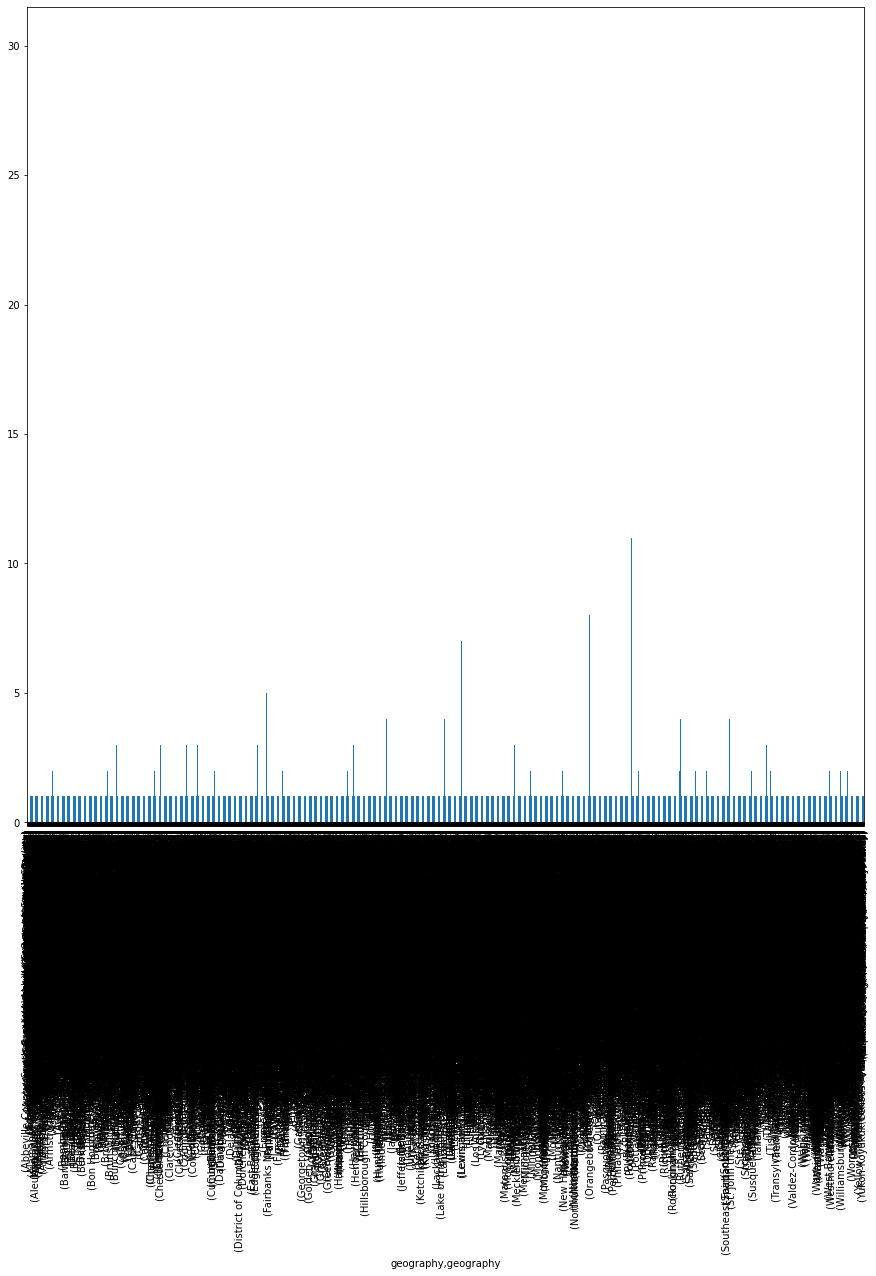

In [42]:
df_g['geography'].value_counts().plot(kind='bar',figsize=(15,15));

In [75]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
lb_make = LabelEncoder()
# apply le on categorical feature columns
df['geography'] = lb_make.fit_transform(df['geography'])
df

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,2334,52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.900000,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,2336,44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.900000,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,2344,54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.900000,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,2532,52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.300000,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,2568,57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.200000,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6089,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,41.1,48.8,1368,51.0,20.9,27.9,40.977034,8.4,32.2,15.2,51.700000,4.3,78.3,54.900000,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
6090,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,29.3,31.4,1454,52.6,26.7,33.9,35.600000,3.8,23.1,12.4,70.100000,4.6,64.5,53.300000,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
6091,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,30.5,31.2,1477,54.8,19.7,44.5,33.300000,2.5,23.0,12.8,64.800000,6.4,62.0,52.600000,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
6092,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,36.9,40.5,1494,58.8,10.9,37.2,40.977034,4.1,36.1,14.4,54.152642,6.9,75.9,56.300000,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


showing how each variable relates to another. The coefficient of 1 across the diagonal makes sense, as a variable is perfectly correlated to itself

In [76]:
# Remove the 'target_deathrate' columns, we want to focus on our independent variables only.
independent_only = df.drop(columns=['target_deathrate','geography'])
# Let's display the correlations between the variables
correlations = independent_only.corr()
correlations

,avganncount,avgdeathsperyear,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,medianagefemale,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
avganncount,1.000000,0.939408,0.073553,0.269145,0.926894,-0.135694,0.082071,-0.024098,-0.124969,-0.122844,-0.106108,-0.143327,-0.182054,0.070159,0.284176,-0.311375,0.321021,0.197981,-0.009016,0.132244,0.166674,0.202349,-0.173548,-0.093699,-0.136501,0.031376,0.435071,0.209184,-0.106221,-0.034508
avgdeathsperyear,0.939408,1.000000,0.062690,0.223207,0.977634,-0.066918,0.063488,-0.024599,-0.148487,-0.144069,-0.181029,-0.136794,-0.151418,0.063322,0.259761,-0.295929,0.293210,0.125015,0.069701,0.056183,0.112221,0.160124,-0.131687,-0.027338,-0.187159,0.084607,0.443074,0.215149,-0.160266,-0.074420
incidencerate,0.073553,0.062690,1.000000,-0.001036,0.026912,0.009046,0.077283,0.018089,-0.014733,-0.009106,-0.119524,-0.170762,0.022644,0.038442,0.046835,0.121725,-0.038177,0.004622,0.099979,0.105174,0.098846,0.149825,0.046109,0.040812,-0.014510,0.113489,-0.008123,-0.208748,-0.152176,-0.118181
medincome,0.269145,0.223207,-0.001036,1.000000,0.235523,-0.788965,0.044003,-0.013288,-0.091663,-0.153278,0.355123,-0.289383,-0.190006,0.101864,0.492810,-0.471348,0.704928,0.676307,-0.453108,0.724175,0.706956,0.747294,-0.754822,-0.719756,0.167225,-0.270232,0.425844,0.083635,0.446083,-0.010195
popest2015,0.926894,0.977634,0.026912,0.235523,1.000000,-0.065299,0.055722,-0.025219,-0.176608,-0.177932,-0.160463,-0.126582,-0.151821,0.065207,0.248375,-0.311849,0.297463,0.139571,0.050768,0.052677,0.121365,0.158650,-0.160066,-0.041469,-0.190095,0.073044,0.464168,0.241468,-0.127979,-0.057740
povertypercent,-0.135694,-0.066918,0.009046,-0.788965,-0.065299,1.000000,-0.055652,-0.029280,-0.214001,-0.148164,-0.642857,0.288106,0.094211,-0.079355,-0.387122,0.194361,-0.531600,-0.719972,0.655148,-0.822534,-0.682760,-0.683100,0.651162,0.798642,-0.509433,0.511530,-0.157289,0.047096,-0.604953,-0.012283
studypercap,0.082071,0.063488,0.077283,0.044003,0.055722,-0.055652,1.000000,-0.026030,-0.036647,-0.030577,-0.038143,-0.090387,-0.057035,0.032604,0.063819,-0.085128,0.108594,0.087669,-0.031957,0.092545,0.068599,0.100063,-0.051497,-0.055512,0.023291,-0.019761,0.062543,-0.015247,-0.051736,0.010676
medianage,-0.024098,-0.024599,0.018089,-0.013288,-0.025219,-0.029280,-0.026030,1.000000,0.129119,0.124678,0.046372,0.006178,0.050574,-0.009180,-0.016909,0.036587,-0.020352,-0.023598,0.018590,0.004665,-0.021466,-0.036926,0.049060,-0.003298,0.035009,-0.017173,-0.038424,-0.030277,0.014504,-0.008276
medianagemale,-0.124969,-0.148487,-0.014733,-0.091663,-0.176608,-0.214001,-0.036647,0.129119,1.000000,0.933696,0.449986,0.100486,0.241310,-0.134864,-0.034135,0.318277,-0.131599,-0.161204,-0.142737,0.082232,-0.147824,-0.208664,0.398967,0.002479,0.398044,-0.242748,-0.238322,-0.266655,0.222278,-0.104105
medianagefemale,-0.122844,-0.144069,-0.009106,-0.153278,-0.177932,-0.148164,-0.030577,0.124678,0.933696,1.000000,0.375208,0.136361,0.242827,-0.153742,-0.070699,0.344840,-0.180845,-0.243469,-0.111161,0.046909,-0.185388,-0.252221,0.455496,0.047659,0.339804,-0.156728,-0.258748,-0.274120,0.161507,-0.098813


#VIF score for each variable###

#VIF score for each variable. create a new dataframe with the inverse of the matrix above.


In [77]:
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)

,avganncount,avgdeathsperyear,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,medianagefemale,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
avganncount,9.773902,-7.291394,-0.255692,-0.156765,-1.901344,-0.286644,-0.139618,0.022080,0.239391,-0.362289,-0.427407,-0.164431,0.220497,0.040261,-0.019010,0.415501,0.516804,-0.566186,0.162484,-1.209096,0.020120,0.234227,-0.416027,-0.114242,0.423347,0.395318,0.025729,-0.065853,0.236985,-0.224652
avgdeathsperyear,-7.291394,31.472220,-0.353551,0.629862,-23.931722,2.159864,0.061885,0.108758,0.366500,-0.871488,0.813613,0.144988,-0.089152,0.034537,-0.417633,-0.287817,-0.760922,0.729940,-0.761922,1.055525,0.455865,-1.284449,-0.208255,-0.333235,-0.386809,-0.277119,0.432431,0.145393,0.713127,0.155781
incidencerate,-0.255692,-0.353551,1.265601,-0.175249,0.522790,-0.026940,-0.054719,-0.027630,0.006991,0.195300,-0.204911,0.061101,-0.065694,-0.008300,0.022494,-0.092219,0.166622,0.003258,-0.134706,-0.529322,-0.069718,-0.103065,-0.118404,-0.378808,-0.116082,-0.153075,0.025166,0.159252,0.355873,0.102196
medincome,-0.156765,0.629862,-0.175249,7.604003,-0.419158,3.775712,0.205635,0.021457,-0.559673,-0.284117,1.462152,-0.528827,-0.538721,0.033361,-0.580311,1.060679,-1.273252,-0.047391,-0.507411,-0.241306,-0.033542,-1.933248,1.894701,-1.715817,1.374467,0.364230,-0.660160,0.020959,-2.324464,-0.218877
popest2015,-1.901344,-23.931722,0.522790,-0.419158,26.468503,-1.630226,0.052587,-0.121058,-0.480501,0.985282,-0.371512,0.023598,-0.096806,-0.076101,0.332778,-0.126180,-0.003428,-0.197506,0.467866,0.356911,-0.473482,0.885322,0.810433,0.131212,-0.220176,-0.290687,-0.955029,-0.333499,-0.845581,0.038086
povertypercent,-0.286644,2.159864,-0.026940,3.775712,-1.630226,8.715099,0.090581,0.054690,0.440492,0.845898,0.663225,-0.049996,0.180447,-0.005262,-0.331807,0.386157,-0.348266,2.071706,-0.060335,2.231968,-0.314748,-0.402695,0.296725,-1.413184,0.260611,-0.783860,-0.268849,0.318653,0.311047,-0.096638
studypercap,-0.139618,0.061885,-0.054719,0.205635,0.052587,0.090581,1.048269,0.023258,0.071743,-0.046709,0.128035,-0.001239,-0.028343,0.015058,0.026466,0.084787,-0.106317,-0.094278,-0.025501,-0.052570,0.073904,-0.170684,-0.164978,0.056177,-0.066443,-0.009063,-0.041199,0.001568,-0.029238,-0.046743
medianage,0.022080,0.108758,-0.027630,0.021457,-0.121058,0.054690,0.023258,1.024278,-0.093276,-0.074709,0.014325,0.007895,-0.024216,-0.015794,0.004118,0.016247,0.010838,-0.030333,-0.086813,0.025030,-0.013900,0.031774,0.038357,0.041668,0.009576,0.013562,0.015398,-0.010682,0.020464,-0.008400
medianagemale,0.239391,0.366500,0.006991,-0.559673,-0.480501,0.440492,0.071743,-0.093276,9.676112,-7.462526,-1.946610,0.027532,-0.206741,-0.144521,-0.257153,-0.461377,-0.630423,-0.259588,-0.417481,1.304517,0.095112,-0.227319,-2.468429,1.986854,-0.108005,0.328398,-0.008504,0.097623,1.027092,0.348220
medianagefemale,-0.362289,-0.871488,0.195300,-0.284117,0.985282,0.845898,-0.046709,-0.074709,-7.462526,10.719672,-0.345531,-0.386108,-0.196641,0.118311,-0.036181,-0.255432,-0.279348,1.084226,0.818048,0.155615,-0.336711,-0.018191,-5.089116,3.406173,-0.626385,-1.358764,-0.045297,0.012602,0.382641,0.059033


In [78]:
revised1 =df.drop(columns=['pctmarriedhouseholds','pctblack','pctwhite','pctpubliccoveragealone','pctpubliccoverage','pctbachdeg25_over','pctprivatecoverage','pctprivatecoveragealone','avganncount','avgdeathsperyear','medincome','popest2015','povertypercent','pctempprivcoverage','medianage','medianagefemale','percentmarried'])

correlations = revised1.corr()
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)

,target_deathrate,incidencerate,studypercap,medianagemale,geography,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctemployed16_over,pctunemployed16_over,pctasian,pctotherrace,birthrate
target_deathrate,1.868900,-0.721875,0.011317,0.288876,-0.005551,-0.015899,-0.162763,0.014855,0.083528,-0.458924,0.349172,-0.281053,0.037974,0.120722,0.085803
incidencerate,-0.721875,1.414612,-0.082590,-0.046145,-0.043106,0.168544,0.069155,-0.001793,-0.086521,-0.025075,-0.260954,-0.106365,-0.024075,0.137878,0.068480
studypercap,0.011317,-0.082590,1.022713,-0.004453,0.015912,0.055627,0.027542,0.015860,0.019403,0.060550,-0.050588,-0.010481,-0.022209,0.019961,-0.026025
medianagemale,0.288876,-0.046145,-0.004453,1.406554,-0.017718,-0.135808,-0.287108,0.006671,-0.230327,-0.238930,0.427561,0.382756,0.139112,0.284738,0.158434
geography,-0.005551,-0.043106,0.015912,-0.017718,1.004456,0.014686,0.052841,0.012882,0.045747,0.004036,-0.003649,0.005172,-0.015576,-0.022817,-0.003167
pctnohs18_24,-0.015899,0.168544,0.055627,-0.135808,0.014686,1.524292,0.416677,0.482607,0.432623,-0.162425,0.256951,-0.021633,0.085496,-0.230904,-0.144264
pcths18_24,-0.162763,0.069155,0.027542,-0.287108,0.052841,0.416677,1.688734,0.585357,0.514533,-0.443425,0.003553,-0.052798,-0.083396,-0.138681,-0.098488
pctsomecol18_24,0.014855,-0.001793,0.015860,0.006671,0.012882,0.482607,0.585357,1.347011,0.235838,-0.028538,0.015387,-0.002432,-0.009454,-0.002254,-0.024950
pctbachdeg18_24,0.083528,-0.086521,0.019403,-0.230327,0.045747,0.432623,0.514533,0.235838,1.751644,0.188787,-0.369914,0.106752,-0.301733,0.027213,0.128364
pcths25_over,-0.458924,-0.025075,0.060550,-0.238930,0.004036,-0.162425,-0.443425,-0.028538,0.188787,1.864682,0.224293,0.275043,0.378538,0.276005,-0.023021


In [0]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = revised1
#drop(columns=['pctmarriedhouseholds','pctblack','pctwhite','pctpubliccoveragealone','pctpubliccoverage','pctbachdeg25_over','pctprivatecoverage','pctprivatecoveragealone','avganncount','avgdeathsperyear','medincome','popest2015','povertypercent','pctempprivcoverage','medianage','medianagefemale','percentmarried'])
y = df['target_deathrate']

X_train, X_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)


In [91]:
X_train.shape

(4875, 16)

In [92]:
X_test.shape

(1219, 16)

In [93]:
y_train.shape

(4875,)

In [94]:
y_test.shape

(1219,)

In [98]:
X = X.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# This is our prediction for ,'target_deathrate' based on our model
X_predict = regressor.predict(X_test)

In [0]:
# We now create the residual by substracting the test value from the predicted 
# value for each row in our dataset
residuals = np.subtract(X_predict, y_test)

In [102]:
# Let's describe our residual:
pd.DataFrame(residuals).describe()

residuals.mean()

-9.384526698718304e-15

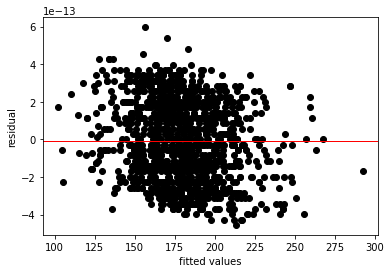

In [104]:
import matplotlib.pyplot as plt

plt.scatter(X_predict, residuals, color='black')
plt.ylabel('residual')
plt.xlabel('fitted values')
plt.axhline(y= residuals.mean(), color='red', linewidth=1)
plt.show()

In [105]:
import scipy as sp

test_result, p_value = sp.stats.bartlett(X_predict, residuals)

# To interpret the results we must also compute a critical value of the chi squared distribution
degree_of_freedom = len(X_predict)-1
probability = 1 - p_value

critical_value = sp.stats.chi2.ppf(probability, degree_of_freedom)
print(critical_value)

# If the test_result is greater than the critical value, then we reject our null
# hypothesis. This would mean that there are patterns to the variance of the data

# Otherwise, we can identify no patterns, and we accept the null hypothesis that 
# the variance is homogeneous across our data

if (test_result > critical_value):
  print('the variances are unequal, and the model should be reassessed')
else:
  print('the variances are homogeneous!')



inf
the variances are homogeneous!
